# Coronavirus Death Rate

Many trajectory plots, such as the superb ones The Financial Times is publishing at https://www.ft.com/coronavirus-latest use raw death and case counts, not per-capita rates.

This notebook explores plotting deaths-per-million, cases-per-million. More generally, MANY statistics can be plotted, including smoothed version of daily changes.

Datasets:

- cases and deaths by country from ECDC
- cases and deaths and tests by US state from covidtracking.com

## Random musings

Datasets wanted:

- location data
- testing by country and state
- population age structure? 
- lockdowns (and other interventions) by country and state

Plot ideas:

- plot rank change to see which ones are trending worse and which are trending better
- plot dpm change / dpm to plot the growth rate (slope) over time
- plt dpm change to plot the rate * base - base, which relates to hospital capacity.

In [9]:
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pandas import to_datetime  # love it!
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

from coronavirus.data import load_all, load_nyc_age_comorbidity_death_data
from coronavirus.data import fill_before_first
from coronavirus.viz import plot_trajectories, days_since_trim

%reload_ext autoreload
%autoreload 2
%matplotlib inline

seasonal_flu_dpm: 114, bad_flu_dpm: 184
seasonal_flu_dpm: 114, bad_flu_dpm: 184


## Load Data

In [15]:
# takes a minute
states_df, countries_df, all_df = load_all(download=False)


seasonal_flu_dpm: 114, bad_flu_dpm: 184
seasonal_flu_dpm: 114, bad_flu_dpm: 184
seasonal_flu_dpm: 114, bad_flu_dpm: 184


In [16]:
states_df.head()
countries_df.head()
df = countries_df
df[df['entity'] == 'United States']

,date,entity,cases,deaths,population,new_cases,new_deaths,cases_per_million,cases_per_day,cases_per_day_7day_avg,...,deaths_per_day,deaths_per_day_7day_avg,deaths_per_day_3day_avg,deaths_per_million_per_day,deaths_per_million_per_day_7day_avg,deaths_per_million_per_day_3day_avg,deaths_per_day_3day_avg_14day_ratio,deaths_per_case,deaths_per_case_per_day_7day_avg,deaths_per_case_per_day_3day_avg
13705,2019-12-31,United States,0,0,327167434.0,0,0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13706,2020-01-01,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
13707,2020-01-02,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
13708,2020-01-03,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
13709,2020-01-04,United States,0,0,327167434.0,0,0,0.000000,0.0,NaN,...,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13823,2020-04-27,United States,965910,54876,327167434.0,26857,1687,2952.341522,26857.0,29460.428571,...,1687.0,2027.714286,1637.666667,5.156381,6.197788,5.005592,0.906792,0.056813,0.068828,0.050787
13824,2020-04-28,United States,988451,56245,327167434.0,22541,1369,3021.238966,22541.0,28671.285714,...,1369.0,1958.000000,1742.666667,4.184402,5.984703,5.326529,1.073071,0.056902,0.068291,0.053387
13825,2020-04-29,United States,1012583,58355,327167434.0,24132,2110,3094.999364,24132.0,26791.714286,...,2110.0,1898.857143,1722.000000,6.449297,5.803931,5.263360,0.948064,0.057630,0.070875,0.070257
13826,2020-04-30,United States,1039909,60966,327167434.0,27326,2611,3178.522346,27326.0,28182.857143,...,2611.0,2026.000000,2030.000000,7.980623,6.192548,6.204774,0.686043,0.058626,0.071888,0.082298


In [17]:
print(f'What states have a population similar to New Zealand?')
print(list(states_df.loc[(states_df['population'] < 5e6) & (states_df['population'] > 3e6), :]
           .groupby('entity').first().sort_values(by='population').index))
print(f'What overlap is there between countries and states?')
print(set(states_df['entity']).intersection(countries_df['entity']))



What states have a population similar to New Zealand?
['Arkansas', 'Nevada', 'Iowa', 'Puerto Rico', 'Utah', 'Connecticut', 'Oklahoma', 'Oregon', 'Kentucky', 'Louisiana', 'Alabama']
What overlap is there between countries and states?
{'Puerto Rico', 'Georgia'}


## Trajectory Plots for deaths or deaths per million vs Date or Days Since

An excellent example of a similar plot of log(DPM) vs days since 0.1 DPM is https://ourworldindata.org/grapher/covid-deaths-days-since-per-million. It visually shows which countries are on similar trajectories, but makes it hard to compare the timeline of when interventions in countries are happening and what their outbreak looked like when those interventions were put in place.

Plotting log(DPM) vs date makes it harder to see the similarities of trajectories (though many of the trajectories look similar. Harder to plot those awesome sloped lines that say "doubles every 2 days", "doubles every 3 days", "doubles every 5 days", etc. Maybe an inset protractor-like graphic showing the doubling times.


### Hospital Beds

What is the medical capacity required to handle the peak of the infection. It depends on how full the beds are, at what rate new patients are coming in, and what rate old patients are leaving (death or recovery).

When plotted on a log(deaths per million) scale, what "slope" can a given amount of medical capacity (ICU beds, ventilators, healthcare workers, PPE, etc.) handle? Assume that the daily change in deaths per million is proportional (accounting for lag and growth changes) to incoming icu cases. For a steady state between incoming ICU cases and outgoing ICU cases (death and recovery), outgoing ICU cases (deaths and recoveries) must equal incoming ICU cases and therefore be proportional to delta deaths per million. And delta deaths per million relates deaths per million * slope. 

Why should we care? As deaths per million goes up, the slope must decrease to match hospital capacity. That means the government response must be stronger and more burdensome.
 
If delta_dpm exceeds this amount, than the number of incoming patients exceeds outgoing and must be absorbed by  available medical capacity. If delta_dpm is less than this amount, the number of incoming patients is less than the number of outgoing patients, and available hospital capacity increases.

low population entities
['Alaska', 'Delaware', 'District of Columbia', 'North Dakota', 'South Dakota', 'Vermont', 'Wyoming']
43 ['Michigan' 'Connecticut' 'Minnesota' 'Indiana' 'Oklahoma' 'New Jersey'
 'New York' 'Massachusetts' 'Washington' 'Ohio' 'Maryland' 'Colorado'
 'Kentucky' 'Pennsylvania' 'Maine' 'Nevada' 'Wisconsin' 'Illinois'
 'Missouri' 'Georgia' 'Arizona' 'Oregon' 'California' 'South Carolina'
 'Alabama' 'Mississippi' 'Florida' 'West Virginia' 'North Carolina'
 'Montana' 'New Mexico' 'Virginia' 'New Hampshire' 'Rhode Island' 'Kansas'
 'Idaho' 'Texas' 'Hawaii' 'Iowa' 'Tennessee' 'Arkansas' 'Nebraska' 'Utah']


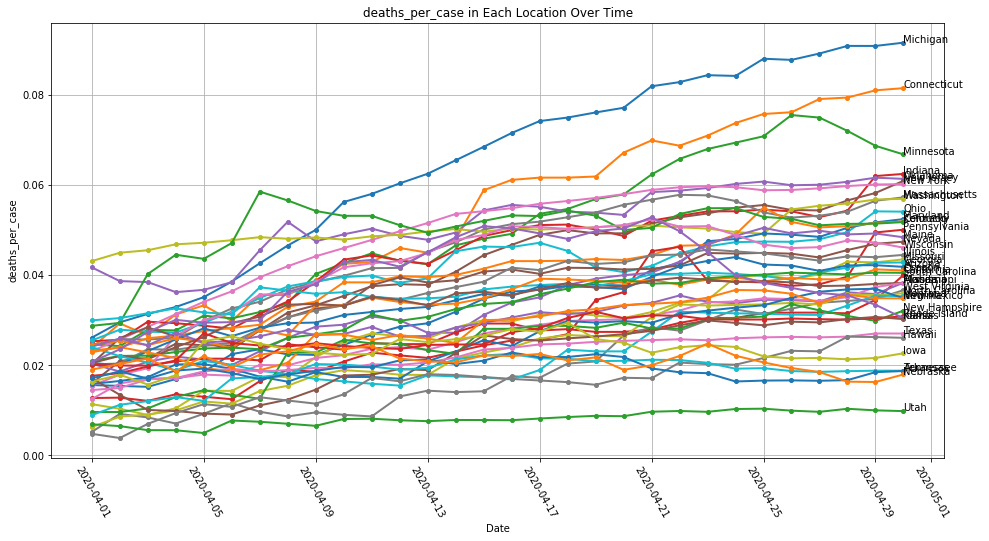

In [20]:
# lockdowns:
# Minnesota - stay-at-home 3/27 https://www.mprnews.org/story/2020/03/25/latest-on-covid19-in-minnesota
# New Zealand - lockdown 3/25 https://www.washingtonpost.com/world/asia_pacific/new-zealand-isnt-just-flattening-the-curve-its-squashing-it/2020/04/07/6cab3a4a-7822-11ea-a311-adb1344719a9_story.html

df = states_df
# df = countries_df
# df = all_df

us_states = list(states_df['entity'].unique())
includes = list(set([
#     'United States',
#     'Japan', 
#     'Singapore', 
#     'South Korea',
#     'Italy', 
#     'Spain', 
#     'France',
    'Vermont', 
    'California',
#     'Washington', 
    'New York', 
    'Michigan', 'Louisiana', 
    'Massachusetts',
#     'Rhode Island',
#             'China',
    'New Zealand',
#     'New York',
#     'EU',
#     countries from https://www.washingtonpost.com/opinions/2020/04/08/is-swedens-lax-approach-coronavirus-backfiring/
    'Sweden',
#     'Denmark', 'Norway', 'Malta', 'United Kingdom', 'Italy',
# States ~3-5M in population
# 'Arkansas', 'Nevada', 'Iowa', 'Puerto Rico', 'Utah', 'Connecticut', 'Oklahoma', 'Oregon',
#              'Kentucky', 'Louisiana', 'Alabama',
    
]
# + us_states
# + eu_countries
))
low_pop_entities = list(df.loc[df['population'] < 1e6, 'entity'].unique())
print(f'low population entities\n{low_pop_entities}')
excludes = list(set([
# Excludes low-population entities with high deaths-per-capita.
'World',
'Puerto Rico',
    'Louisiana'
] 
    + low_pop_entities
))

# index_col = 'days_since'
index_col = 'date'
log_yaxis = False

# values_col = 'deaths_per_million'; log_yaxis = True
# values_col = 'deaths_per_million_per_day_7day_avg'; log_yaxis = False
# values_col = 'deaths_per_million_per_day_3day_avg'; log_yaxis = False
# values_col = 'deaths'
# values_col = 'deaths_per_day'
# values_col = 'deaths_ratio_per_day_7day_avg'
# values_col = 'deaths_per_day_7day_avg'
values_col = 'deaths_per_case'; log_yaxis = False
# values_col = 'deaths_per_case_per_day_7day_avg'; log_yaxis = False
# values_col = 'cases_per_million'; log_yaxis = False
# values_col = 'cases_per_million_per_day_7day_avg'; log_yaxis = False
# values_col = 'cases_per_million_per_day_3day_avg'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg'
# values_col = 'cases'
# values_col = 'cases_per_test'; log_yaxis = False
# values_col = 'cases_per_day_7day_avg_tests_per_day_7day_avg_ratio'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg_14day_ratio'; log_yaxis = False
# values_col = 'cases_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio'; log_yaxis = False
# values_col = 'cases_per_test_per_day_3day_avg_14day_ratio'; log_yaxis = False
# values_col = 'deaths_per_test'; log_yaxis = False
# values_col = 'deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio'; log_yaxis = False
# values_col = 'deaths_per_test_per_day_3day_avg_14day_ratio'; log_yaxis = False

# FT threshold condition https://www.ft.com/coronavirus-latest 2020-03-02
# days_since_col = 'deaths_per_day'; days_since_thresh = 3.0
# FT thesh: number of days since 30 daily cases first recorded
# days_since_col = 'cases_per_day'; days_since_thresh = 30
# OWID threshold condition https://ourworldindata.org/grapher/covid-deaths-days-since-per-million
# days_since_col = 'deaths_per_million'; days_since_thresh = 0.1
# Other thresholds
# days_since_col = 'cases_per_million'; days_since_thresh = 1
# days_since_col = 'deaths'; days_since_thresh = 1
# days_since_col = 'cases'; days_since_thresh = 1
# days_since_col = 'deaths_per_day'; days_since_thresh = 1.0
# Good for 14day deaths/test ratio and cases/test ratio b/c earlier the ratio is huge.
# days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-15')
days_since_col = 'date'; days_since_thresh = pd.to_datetime('2020-04-01')

n_top = 52
# n_top = len(includes)
n_show = n_top
rank = False
# rank = True
ascending = False
# ascending = True  # for cases/test 14day ratio, lower is better

piv = plot_trajectories(days_since_trim(df, index_col, values_col, days_since_col, days_since_thresh),
                        index_col=index_col, values_col=values_col, 
                        rank=rank, n_top=n_top, n_show=n_show,
                        includes=includes, excludes=excludes,
                        log_yaxis=log_yaxis,
                        ascending=ascending,
                        show_legend=False,
                       )


In [8]:
(df.loc[(df['entity'].isin(['California', 'New York'])) &
       (df['date'] < to_datetime('2020-03-24')) & (df['date'] > to_datetime('2020-03-10')),
       ['date', 'entity', 'tests', 'cases', 'deaths']]
 .sort_values(by=['date', 'entity'])).fillna(0.0)

,date,entity,tests,cases,deaths
275,2020-03-11,California,1073.0,157.0,0.0
1963,2020-03-11,New York,308.0,216.0,0.0
274,2020-03-12,California,1118.0,202.0,4.0
1962,2020-03-12,New York,308.0,216.0,0.0
273,2020-03-13,California,1118.0,202.0,4.0
1961,2020-03-13,New York,3200.0,421.0,0.0
272,2020-03-14,California,1168.0,252.0,5.0
1960,2020-03-14,New York,3303.0,524.0,0.0
271,2020-03-15,California,1209.0,293.0,5.0
1959,2020-03-15,New York,5272.0,729.0,3.0
